# Imports

In [1]:
import warnings
import datetime
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from src.functions import CorrClass as cs
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 12,40

cs = cs()

# Set rules

In [2]:
MIN_ADD = datetime.timedelta(seconds = 60)
HOUR_ADD = 60 * MIN_ADD
DAY_ADD = HOUR_ADD * 24 

# Get data

In [3]:
dfMarketData = pd.read_csv('WDODATA.csv','\t')
dfMarketData.columns = ['Date','Time','Open','High','Low','Close','TickVol','Vol','Spread']
dfMarketData['Datetime'] = dfMarketData['Date'].str.replace('.','-') + ' ' + dfMarketData['Time']
dfMarketData = dfMarketData[['Datetime','Open','High','Low','Close']]
dfMarketData['Datetime'] = pd.to_datetime(dfMarketData['Datetime'])
dfMarketData = dfMarketData.set_index('Datetime')
dfMarketData = dfMarketData.sort_index()

In [4]:
dfEventsData = pd.read_csv('EventsData.csv')
dfEventsFromTo = pd.read_csv('EventsFromTo.csv')
dfEventsFromTo=dfEventsFromTo.set_index('EventID').T
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData['PercentChng'] = dfEventsData['ActualValue']/dfEventsData['PreviousValue']-1
dfEventsData['DummyChng'] = 0
dfEventsData.loc[dfEventsData['ActualValue']-dfEventsData['PreviousValue']>0, 'DummyChng'] = 1
dfEventsData.loc[dfEventsData['ActualValue']-dfEventsData['PreviousValue']<0, 'DummyChng'] = -1
dfEventsData['Date'] = dfEventsData['ReleaseTime'].apply(lambda x: datetime.datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
dfEventsData = dfEventsData.loc[dfEventsData['ReleaseTime'] > min(dfMarketData.index),:]
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData = dfEventsData.set_index('ReleaseTime')
dfEventsData = dfEventsData.sort_index()

# Split train/test

In [5]:
dfEventsDataTrain=dfEventsData[dfEventsData.index<=datetime.datetime.combine(dfEventsData.iloc[int(.7*len(dfEventsData)),:]['Date'], datetime.datetime.min.time())]
dfEventsDataTest=dfEventsData[dfEventsData.index>datetime.datetime.combine(dfEventsData.iloc[int(.7*len(dfEventsData)),:]['Date'], datetime.datetime.min.time())]
dfMarketDataTrain=dfMarketData.loc[dfMarketData.index<datetime.datetime.combine(max(dfEventsDataTrain.index).date(), datetime.datetime.min.time())+DAY_ADD]
dfMarketDataTest=dfMarketData[dfMarketData.index>=datetime.datetime.combine(max(dfMarketDataTrain.index).date(), datetime.datetime.min.time())]

# Calculate variation after releases

In [6]:
def variationRatio(
    dfEventsData,
    dfMarketData
) -> pd.DataFrame():
    df = pd.DataFrame()
    for idx, release in dfEventsData.iterrows():
        mktdata_on_release = idx
        mktdata_after_release = mktdata_on_release + MIN_ADD * 5
        mktdata_pre_release = mktdata_on_release - MIN_ADD * 5
        df_mktdata_release = dfMarketData[(dfMarketData.index >= mktdata_on_release) & (dfMarketData.index <= mktdata_after_release)]
        df_mktdata_pre_release = dfMarketData[(dfMarketData.index <= mktdata_on_release) & (dfMarketData.index >= mktdata_pre_release)]
        if not df_mktdata_release.empty and not df_mktdata_pre_release.empty:
            release_price = -1
            try:
                release_price = df_mktdata_release['Open'][mktdata_on_release]
            except:
                try:
                    release_price = df_mktdata_release['Close'][mktdata_on_release - MIN_ADD]
                except:
                    continue
            variation_after_release = max(abs(release_price-max(df_mktdata_release['High'])),abs(release_price-min(df_mktdata_release['Low'])))
            variation_pre_release = max(abs(release_price-max(df_mktdata_pre_release['High'])),abs(release_price-min(df_mktdata_pre_release['Low'])))
            variation_diff = variation_after_release/variation_pre_release-1
            df = df.append(
                {
                    'EventID': dfEventsFromTo[int(release['EventID'])]['EventName'],
                    'Ratio': variation_diff
                }, ignore_index=True 
            )
    dict_data = {}
    for idx, data in df.iterrows():
        if data['EventID'] in dict_data.keys():
            dict_data[data['EventID']].append(data['Ratio'])
        else:
            dict_data[data['EventID']]=[data['Ratio']]
    df = pd.DataFrame.from_dict(dict_data, orient='index')
    df = df.transpose()
    return df

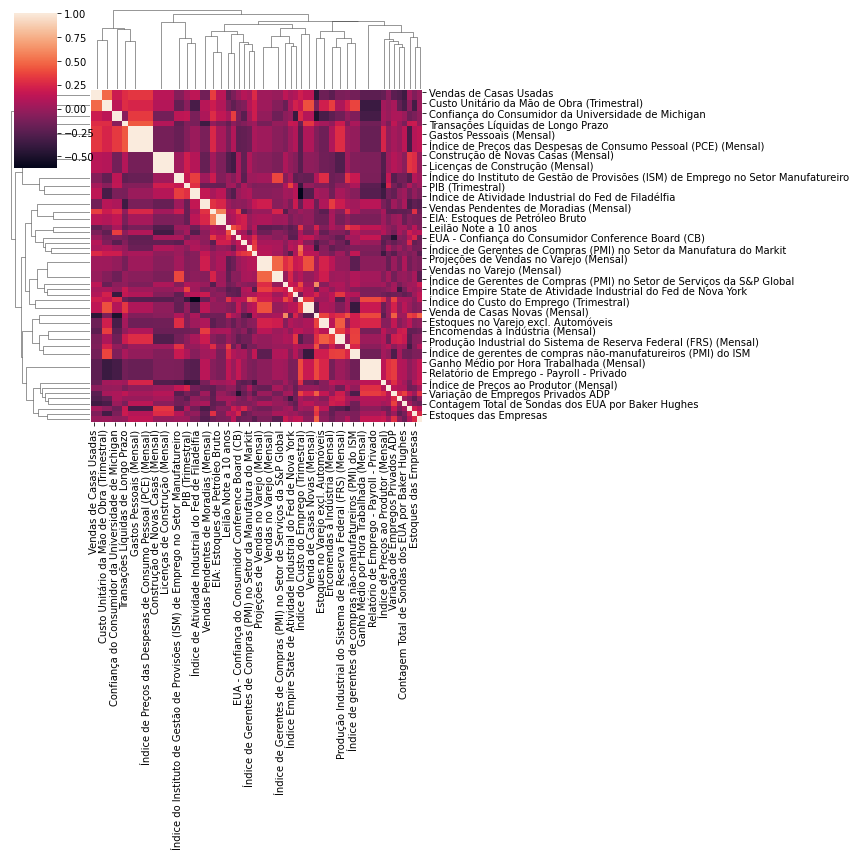

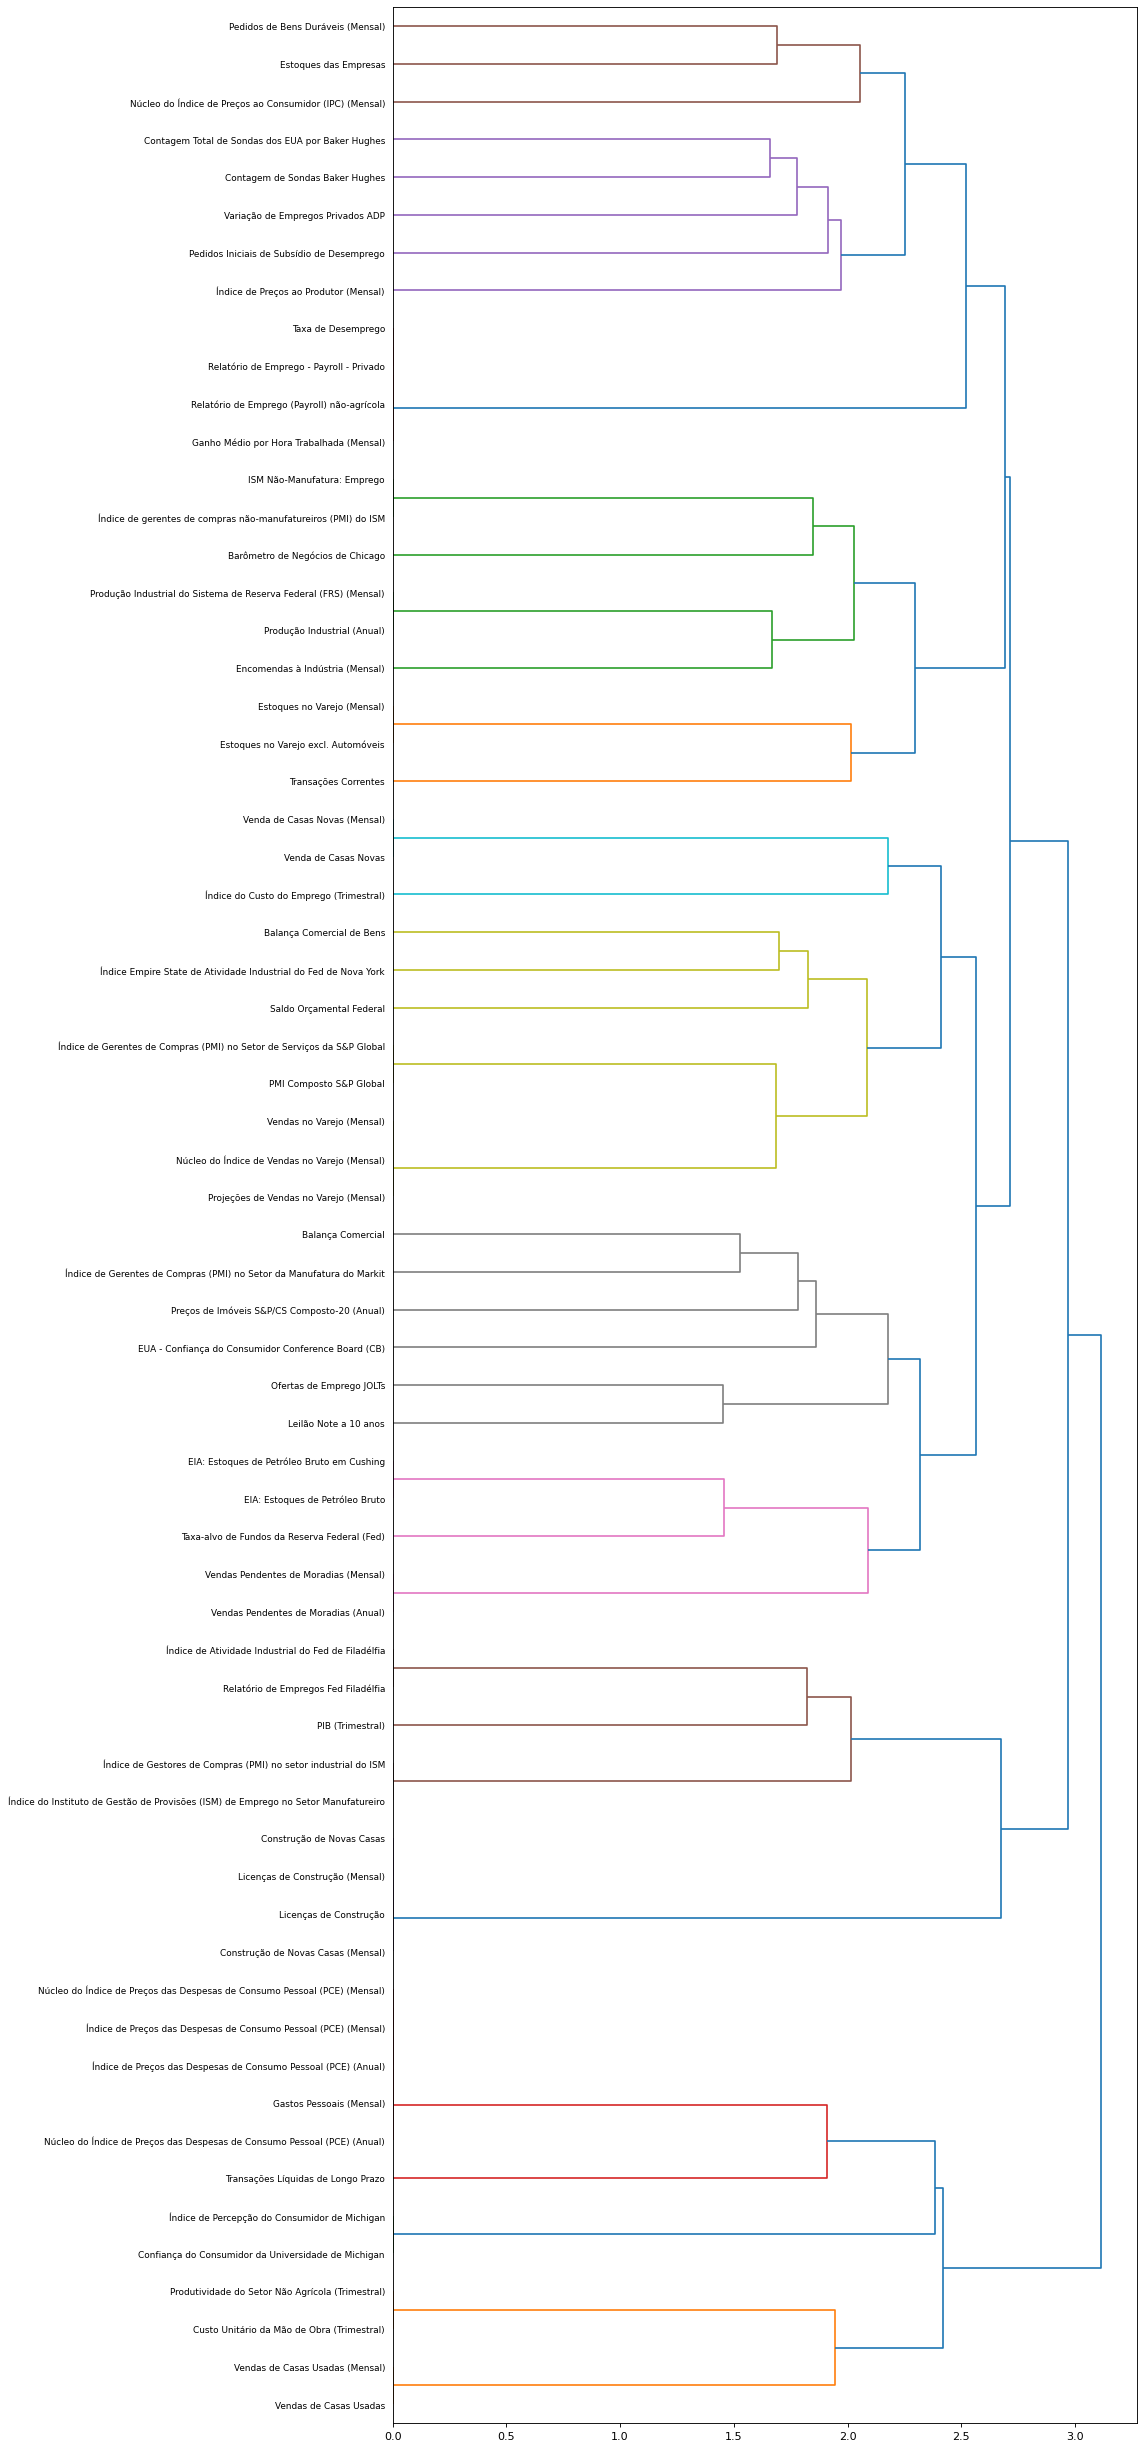

In [7]:
dfTrain = variationRatio(dfEventsData=dfEventsDataTrain,dfMarketData=dfMarketDataTrain)
dendTrain=cs.plot_heatmap_dendogram(dfTrain,'dend_train')

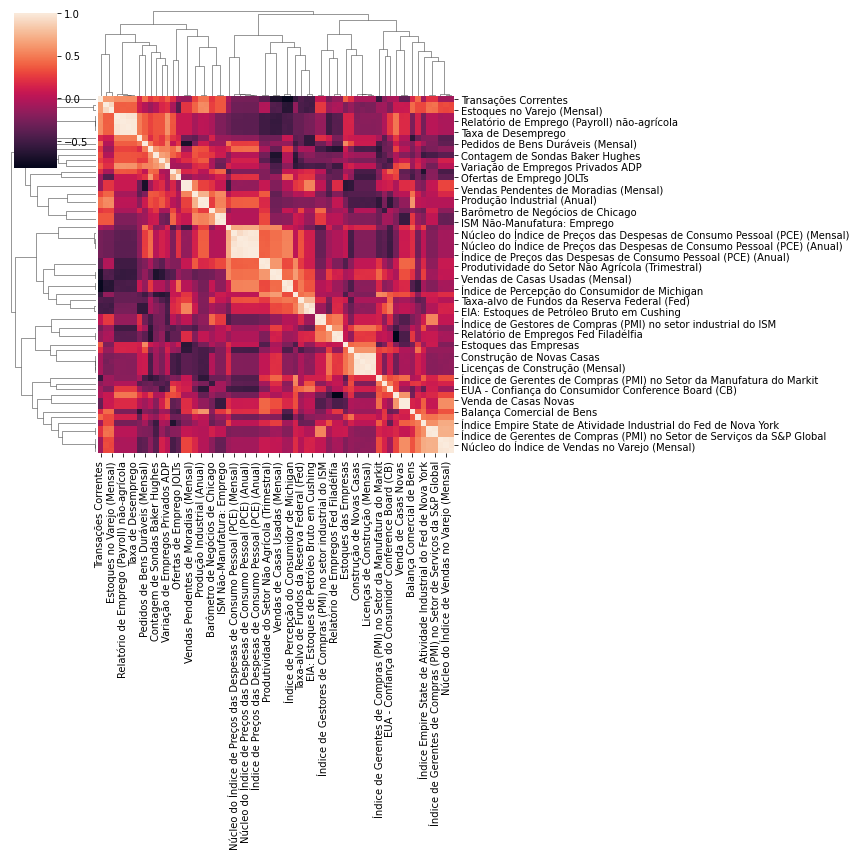

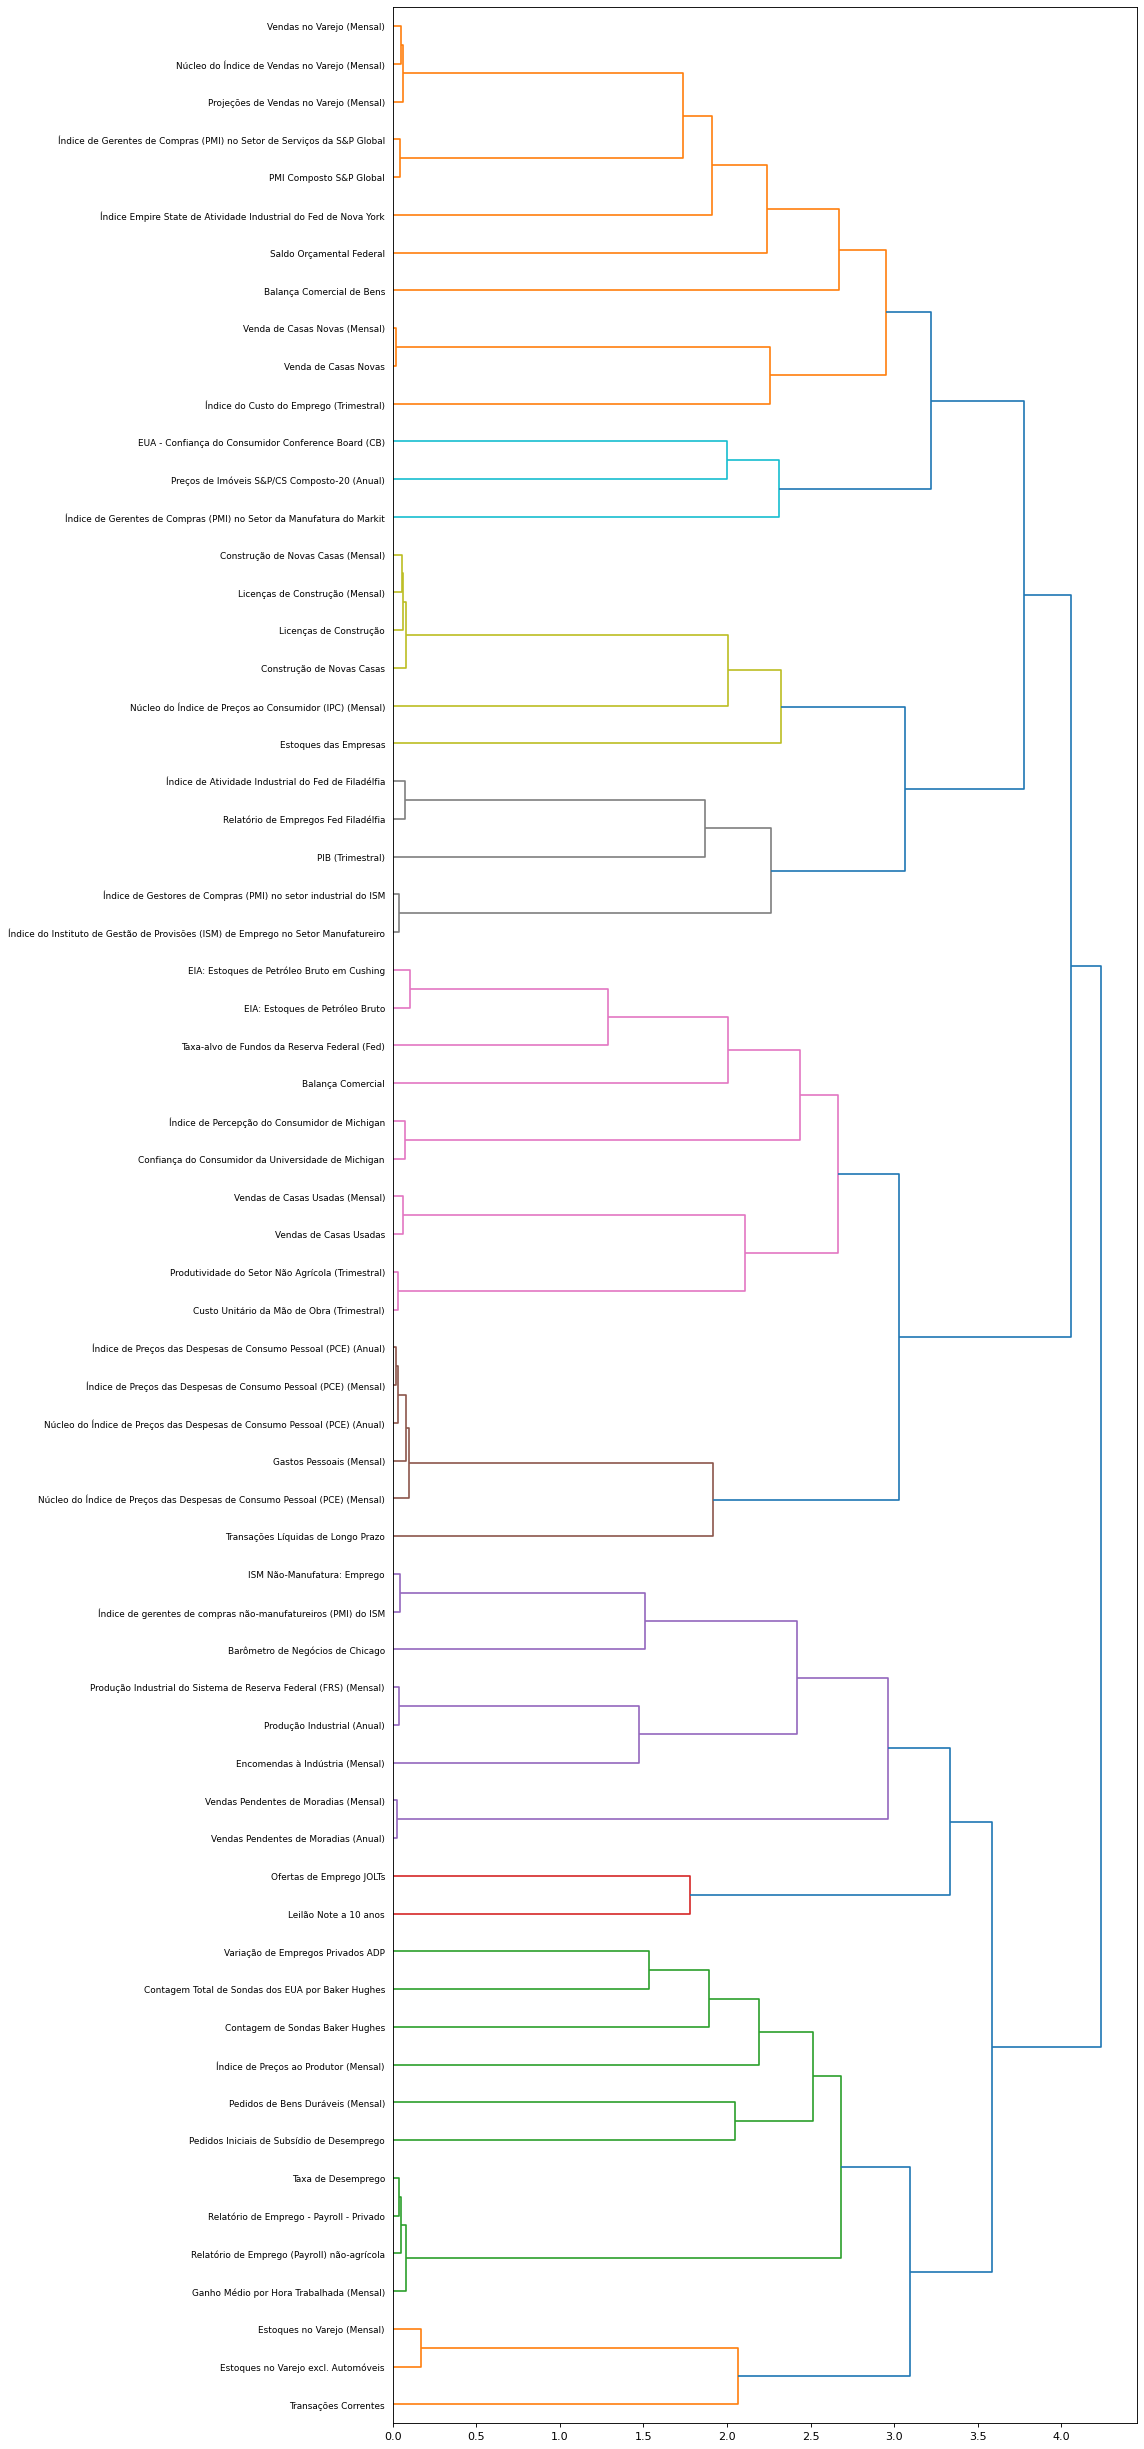

In [8]:
dfTrainDenoised = cs.cov2corr(cs.cleanMatrix(dfTrain))
dendTrainDenoised=cs.plot_heatmap_dendogram(dfTrainDenoised,'dend_train_denoised')

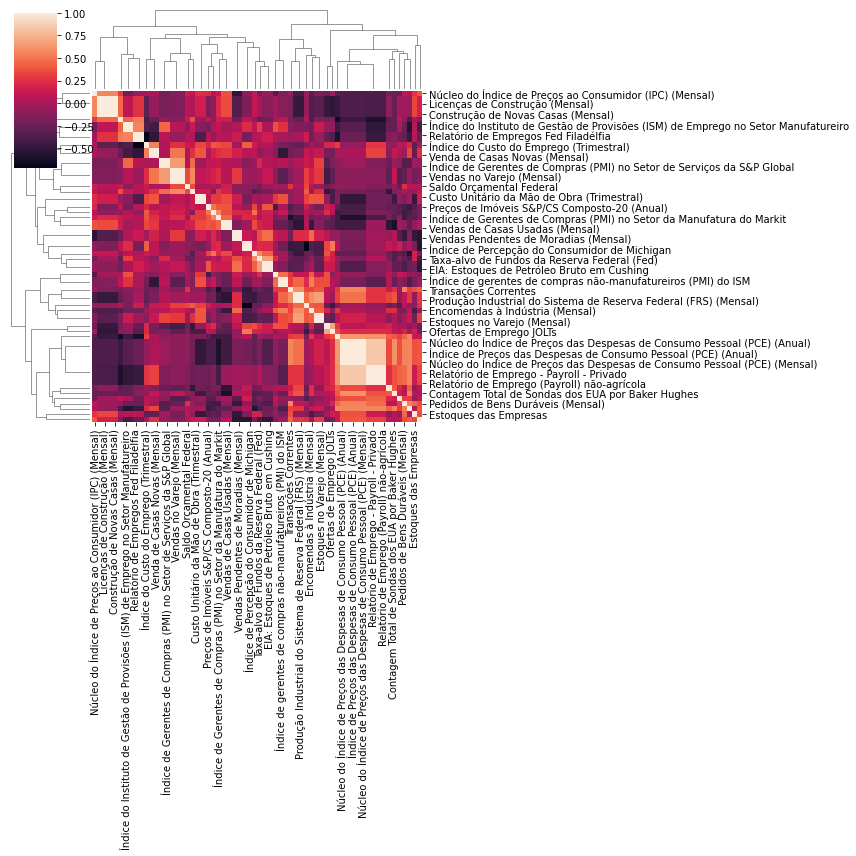

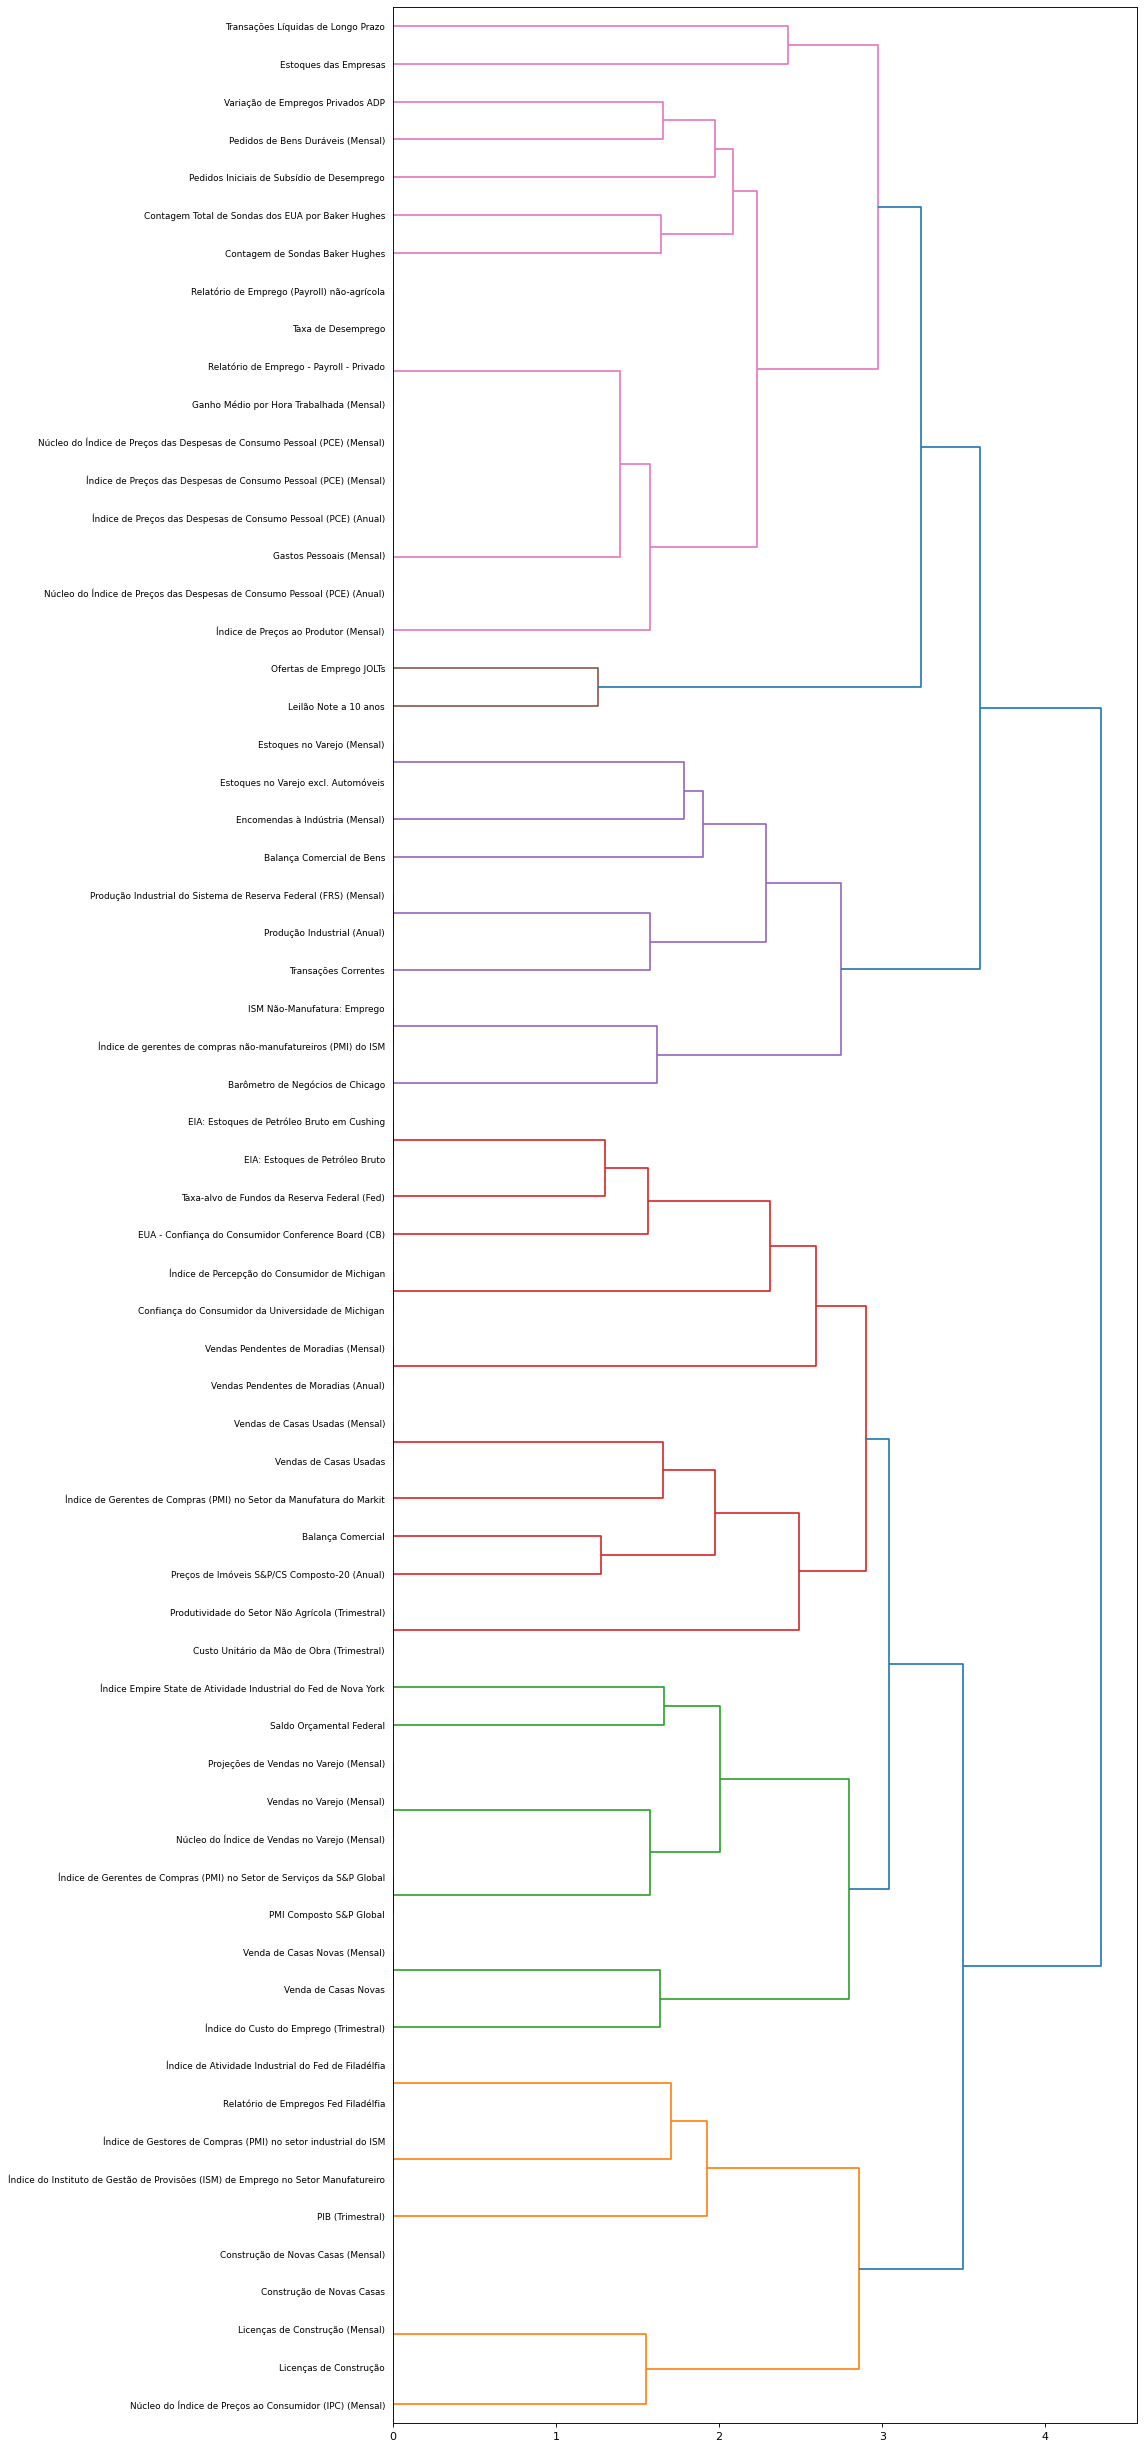

In [9]:
dfTrainDetoned = cs.cov2corr(cs.detonMatrix(dfTrain))
dendTrainDetoned=cs.plot_heatmap_dendogram(dfTrainDetoned,'dend_train_detoned')

In [37]:
chosenDend=dendTrainDenoised

In [38]:
dict_related = {}
idx_group = 1
for i in range(0,len(chosenDend['ivl'])):
    color = chosenDend['leaves_color_list'][i][-1]
    key = f'Group_{color}'
    if key in dict_related.keys():
        dict_related[key].append(chosenDend['ivl'][i])
    else:
        dict_related[key]=[chosenDend['ivl'][i]]

In [39]:
df_groups = pd.DataFrame.from_dict(dict_related, orient='index')
df_groups = df_groups.transpose()

In [40]:
df_groups

,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9
0,Transações Correntes,Ganho Médio por Hora Trabalhada (Mensal),Leilão Note a 10 anos,Vendas Pendentes de Moradias (Anual),Transações Líquidas de Longo Prazo,Custo Unitário da Mão de Obra (Trimestral),Índice do Instituto de Gestão de Provisões (IS...,Estoques das Empresas,Índice de Gerentes de Compras (PMI) no Setor d...
1,Estoques no Varejo excl. Automóveis,Relatório de Emprego (Payroll) não-agrícola,Ofertas de Emprego JOLTs,Vendas Pendentes de Moradias (Mensal),Núcleo do Índice de Preços das Despesas de Con...,Produtividade do Setor Não Agrícola (Trimestral),Índice de Gestores de Compras (PMI) no setor i...,Núcleo do Índice de Preços ao Consumidor (IPC)...,Preços de Imóveis S&P/CS Composto-20 (Anual)
2,Estoques no Varejo (Mensal),Relatório de Emprego - Payroll - Privado,None,Encomendas à Indústria (Mensal),Gastos Pessoais (Mensal),Vendas de Casas Usadas,PIB (Trimestral),Construção de Novas Casas,EUA - Confiança do Consumidor Conference Board...
3,Índice do Custo do Emprego (Trimestral),Taxa de Desemprego,None,Produção Industrial (Anual),Núcleo do Índice de Preços das Despesas de Con...,Vendas de Casas Usadas (Mensal),Relatório de Empregos Fed Filadélfia,Licenças de Construção,None
4,Venda de Casas Novas,Pedidos Iniciais de Subsídio de Desemprego,None,Produção Industrial do Sistema de Reserva Fede...,Índice de Preços das Despesas de Consumo Pesso...,Confiança do Consumidor da Universidade de Mic...,Índice de Atividade Industrial do Fed de Filad...,Licenças de Construção (Mensal),None
5,Venda de Casas Novas (Mensal),Pedidos de Bens Duráveis (Mensal),None,Barômetro de Negócios de Chicago,Índice de Preços das Despesas de Consumo Pesso...,Índice de Percepção do Consumidor de Michigan,None,Construção de Novas Casas (Mensal),None
6,Balança Comercial de Bens,Índice de Preços ao Produtor (Mensal),None,Índice de gerentes de compras não-manufatureir...,None,Balança Comercial,None,None,None
7,Saldo Orçamental Federal,Contagem de Sondas Baker Hughes,None,ISM Não-Manufatura: Emprego,None,Taxa-alvo de Fundos da Reserva Federal (Fed),None,None,None
8,Índice Empire State de Atividade Industrial do...,Contagem Total de Sondas dos EUA por Baker Hughes,None,None,None,EIA: Estoques de Petróleo Bruto,None,None,None
9,PMI Composto S&P Global,Variação de Empregos Privados ADP,None,None,None,EIA: Estoques de Petróleo Bruto em Cushing,None,None,None


# Releases frequency 

In [14]:
dfToStudy = pd.read_csv('EventsData.csv')
dfToStudy['ReleaseTime'] = pd.to_datetime(dfToStudy['ReleaseTime'])
dfToStudy['PercentChng'] = dfToStudy['ActualValue']/dfToStudy['PreviousValue']-1
dfToStudy['DummyChng'] = 0
dfToStudy.loc[dfToStudy['ActualValue']-dfToStudy['PreviousValue']>0, 'DummyChng'] = 1
dfToStudy.loc[dfToStudy['ActualValue']-dfToStudy['PreviousValue']<0, 'DummyChng'] = -1
dfToStudy['Date'] = dfToStudy['ReleaseTime'].apply(lambda x: datetime.datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
dfToStudy['ReleaseTime'] = pd.to_datetime(dfToStudy['ReleaseTime'])
dfToStudy = dfToStudy.set_index('ReleaseTime')
dfToStudy = dfToStudy.sort_index()
dfToStudy = dfToStudy.dropna()

In [15]:
dfFrequenciesFromTo = pd.read_csv('FrequencyFromTo.csv')
eventsFromTo = pd.read_csv('EventsFromTo.csv')
data_result = {}
for group in df_groups.columns:
    data_result[group] = []
    for row in df_groups[group]:
        if row == None:
            continue
        frequency = eventsFromTo[eventsFromTo['EventName']==row]['Frequency'].reset_index(drop=True).T[0]
        data_result[group].append({
            'ID': eventsFromTo[eventsFromTo['EventName']==row]['EventID'].reset_index(drop=True).T[0],
            'Event': row,
            'Frequency': frequency
        })

# DOING

# Estimate numbers

In [22]:
print(f'Previous lenght {len(dfEventsData)}')
dfEventsData = pd.read_csv('EventsData.csv')
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData['PercentChng'] = dfEventsData['ActualValue']/dfEventsData['PreviousValue']-1
dfEventsData['DummyChng'] = 0
dfEventsData.loc[dfEventsData['ActualValue']-dfEventsData['PreviousValue']>0, 'DummyChng'] = 1
dfEventsData.loc[dfEventsData['ActualValue']-dfEventsData['PreviousValue']<0, 'DummyChng'] = -1
dfEventsData['Date'] = dfEventsData['ReleaseTime'].apply(lambda x: datetime.datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData = dfEventsData.set_index('ReleaseTime')
dfEventsData = dfEventsData.sort_index()
dfEventsData = dfEventsData.dropna()

dict_data = {}
i = 0
data_to_append = {}
for idx, data in dfEventsData.iterrows():
    data_to_append[i] = {
        'EventID': int(data['EventID']),
        'EventName': dfEventsFromTo[int(data['EventID'])]['EventName'],
        'ActualValue': data['ActualValue'],
        'BinaryChng': data['DummyChng'],
        'ReleaseTime': idx
    }
    i += 1
dfReleases = pd.DataFrame.from_dict(data_to_append, orient='index')
print(f'Current lenght {len(dfEventsData)}')

Previous lenght 13051
Current lenght 13051


# Modelling

In [17]:
teste = pd.read_csv('GroupsOrderToPredict.csv')

teste1 = teste[teste['Group']=='Group_1']
teste2 = teste1[teste['Sequence']<teste[teste['ID']==840020027]['Sequence'].values[0]]
teste2

,ID,Sequence,Group
0,840500003,0,Group_1
1,840500002,0,Group_1


In [85]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

model_list = [LogisticRegression(),DecisionTreeClassifier(),KNeighborsClassifier(n_neighbors=1)]

result_dict = {}
all_df_models = {}
dfGroupsToPredict = pd.read_csv('GroupsOrderToPredict.csv')

for possible_columns in df_groups.columns:
    events = list(df_groups[possible_columns].dropna())
    k = pd.to_datetime(pd.Timestamp.min)
    current_data = {}
    release_idx = {}
    for event in events:
        eventID = dfEventsFromTo.T[dfEventsFromTo.T['EventName']==event].index[0]
        if k not in current_data.keys():
            current_data[k] = {eventID:float('NaN')}
            release_idx[k] = {eventID:float('NaN')}
        else:
            if event not in current_data[k].keys():
                current_data[k] = current_data[k]|{eventID:float('NaN')}
                release_idx[k] = release_idx[k]|{eventID:float('NaN')}

    last_current = k
    last_release_idx = k
    default = {}
    for event in events:
        keys = dfEventsFromTo.T[dfEventsFromTo.T['EventName']==event].index[0]
        default = default|{keys:False}
        
    for idx, release in dfReleases.iterrows():
        idx = pd.to_datetime(release['ReleaseTime'])
        event = release['EventName']
        if event not in events:
            continue
        eventID = dfEventsFromTo.T[dfEventsFromTo.T['EventName']==event].index[0]
        release_idx[idx] = default.copy()|release_idx[idx] if idx in release_idx.keys() else default.copy()
        current_data[idx] = current_data[last_current]|{eventID:release['ActualValue']} if idx not in current_data.keys() else current_data[idx]|{eventID:release['ActualValue']}
        last_current = idx
        release_idx[idx][eventID]=True

    df_current_data = pd.DataFrame(current_data).T
    df_current_data = df_current_data.reset_index(drop=True)
    minimum = min(df_current_data.count())
    maximum = max(df_current_data.count())
    df_current_data = df_current_data.loc[minimum:maximum].reset_index(drop=True)
    df_release_idx = pd.DataFrame(release_idx).T
    df_release_idx = df_release_idx.reset_index(drop=True)
    df_release_idx = df_release_idx.loc[minimum:maximum].reset_index(drop=True)
    for i in range(0,len(df_groups[possible_columns])):
        label = df_groups[possible_columns][i]
        if label == None:
            continue
        label = dfEventsFromTo.T[dfEventsFromTo.T['EventName']==label].index[0]
        df = df_current_data.iloc[df_current_data[df_release_idx[label]].index].reset_index(drop=True)
        if df.empty or len(df.index) < 10:
            continue
        all_df_models[possible_columns] = df
        y = df[label]
        teste1 = teste[teste['Group']==possible_columns]
        teste2 = teste1[teste['Sequence']<teste[teste['ID']==label]['Sequence'].values[0]]
        X = df[list(teste2['ID'])]

        if len(X.columns) < 1:
            continue

        X = X.shift(1)
        X = X.fillna(0)
        X=X.reset_index(drop=True)
        y=y.reset_index(drop=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

        result_dict[label] = {
                'Group': possible_columns,
                'Features': list(X.columns),
                'y_test': list(y_test),
                'models': []
            }
        for model in model_list:
            pipe = Pipeline([
                ('regressor', model)
            ])

            pipe.fit(X_train, y_train)
            
            y_pred = pipe.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)

            result = {
                'TrainScore': pipe.score(X_train, y_train),
                'TestScore': pipe.score(X_test, y_test)
            }

            if not (result['TrainScore'] > .6 and result['TestScore'] > .5):
                continue

            result_dict[label]['models'].append({
                'Name': str(model),
                'Label': label,
                'Pointer': pipe['regressor'],
                'MSE': mse,
                'RMSE': rmse,
                'y_pred': list(y_pred),
                'Score': result['TestScore'],
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test,
                'X': X,
                'y': y
            })

            dfToPlot = pd.DataFrame({
                'YPred': pipe['regressor'].predict(X),
                'Y': y,
            })

            fig = px.line(dfToPlot, x=dfToPlot.index, y=dfToPlot.columns, title=f'{dfEventsFromTo[label][0]} - {str(model)}')
            fig.show();